## MobileNetV2

In [ ]:
import imageio.v2 as imageio
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.mobilenet_v2 import decode_predictions
from keras.applications.mobilenet_v2 import MobileNetV2



In [68]:
import os
os.chdir("c:\\Users\\riandrea\\Desktop\\Github\\SceneDetect")
os.getcwd()


'c:\\Users\\riandrea\\Desktop\\Github\\SceneDetect'

In [32]:
MobileNetV2 = MobileNetV2(weights='imagenet')
MobileNetV2

<Functional name=mobilenetv2_1.00_224, built=True>

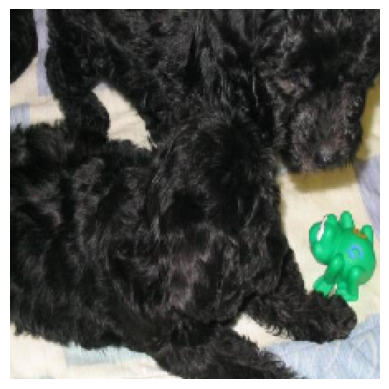

In [33]:
# Bild laden
image_path = r"cats_and_dogs_small\test\dogs\1509.jpg"

# Bild auf die gewünschte Eingabegröße skalieren unsere Modell nimmt 180 x 180 x3
img = image.load_img(image_path, target_size=(224, 224))

# Bild anzeigen
plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
img = imageio.imread(image_path)

# Bild auf die gewünschte Größe (224, 224) skalieren
img_resized = Image.fromarray(img).resize((224, 224))

# Bild in das numpy Array einfügen
data = np.empty((1, 224, 224, 3))
data[0] = np.array(img_resized)

In [35]:
data = preprocess_input(data)
data.shape

(1, 224, 224, 3)

In [36]:
predictions = MobileNetV2.predict(data)
print('Shape: {}'.format(predictions.shape))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Shape: (1, 1000)


In [37]:
output_neuron = np.argmax(predictions[0])
print('Most active neuron: {} ({:.2f}%)'.format(
    output_neuron,
    100 * predictions[0][output_neuron]
))


Most active neuron: 183 (37.33%)


In [38]:
for name, desc, score in decode_predictions(predictions)[0]:
    print('- {} ({:.2f}%)'.format(desc, 100 * score))

- Kerry_blue_terrier (37.33%)
- Bouvier_des_Flandres (15.36%)
- Scotch_terrier (11.63%)
- toy_poodle (5.85%)
- affenpinscher (3.98%)


---
## Fine tune MobileNetV2

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow import keras

In [60]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [49]:
#MobileNetV2.summary()

In [61]:
base_model.trainable = False


In [62]:
# Build the new model
MobileNetV2_finetuned = models.Sequential([
    base_model,  # Include the MobileNetV2 as the base
    layers.GlobalAveragePooling2D(),  # Apply Global Average Pooling
    layers.Dense(1024, activation='relu'),  # Fully connected layer
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [63]:
MobileNetV2_finetuned.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [64]:
MobileNetV2_finetuned.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [65]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,  
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [66]:
train_dir = r'user_pictures\100_pic_train'            # Dein Trainingsdaten-Verzeichnis
validation_dir = r'user_pictures/100_pic_valid'  # Dein Validierungsdaten-Verzeichnis

#Achtung die Klassen werden aus dem Verzeichnis erstellt wir haben in dem Ornder "100_pic" zwei Weitere Ordner namens Cat und Dogs 
# woraus sich die Klassen herausstellen haben wir weitere Ordner wie Pferd und Wolf haben wir 4 Klassen
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

Found 202 images belonging to 2 classes.


Found 202 images belonging to 2 classes.


In [67]:
import json
import os

# Überprüfen, ob das Modell bereits existiert umso Ressourcen zupassen falls ein Modell bereits hinterlegt wurde
path_to_model = r"model/fine_tuned_model.keras"

if os.path.isfile(path_to_model):
    history = load_model(path_to_model)
    print("exist")

else:       
    # Falls kein Modell da ist wird das Modell trainiert und nur das Beste modell gespeichert.
    # Trainiere das Modell
    history = MobileNetV2_finetuned.fit(
        train_generator,
        epochs=8,
        validation_data=validation_generator,
        callbacks=[  
            keras.callbacks.ModelCheckpoint('model/fine_tuned_model.keras', 
                                            save_best_only=True, 
                                            monitor='val_loss')
        ]
    )
    
    # Die Parameter in History werden zwischen gespeichert in einer JSON da sonst später die History nicht ausgeben werden kann.

    history_dict = history.history  # Das History-Objekt enthält alle Metriken
    with open('train_history.json', 'w') as json_file:
        json.dump(history_dict, json_file, indent=4)


c:\Users\riandrea\Desktop\Github\SceneDetect\project\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 689ms/step - accuracy: 0.7364 - loss: 0.5700 - val_accuracy: 0.9554 - val_loss: 0.1413
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - accuracy: 0.9435 - loss: 0.1370 - val_accuracy: 0.9604 - val_loss: 0.1422
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 728ms/step - accuracy: 0.9268 - loss: 0.2169 - val_accuracy: 0.9901 - val_loss: 0.0683
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 672ms/step - accuracy: 0.9600 - loss: 0.1022 - val_accuracy: 0.9653 - val_loss: 0.0910
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 766ms/step - accuracy: 0.9621 - loss: 0.1140 - val_accuracy: 0.9851 - val_loss: 0.0224
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 708ms/step - accuracy: 0.9918 - loss: 0.0482 - val_accuracy: 0.9950 - val_loss: 0.0196
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 641ms/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 0.9752 - val_loss: 0.0758
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 699ms/step - accuracy: 0.9901 - loss: 0.0541 - val_accuracy: 0.9950 - val_loss: 0.0094


In [68]:
# Evaluierung des Modells auf den Validierungsdaten
eval_results = MobileNetV2_finetuned.evaluate(validation_generator)
print(f"Loss: {eval_results[0]}")
print(f"Accuracy: {eval_results[1]}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9931 - loss: 0.0102
Loss: 0.009371306747198105
Accuracy: 0.9950494766235352


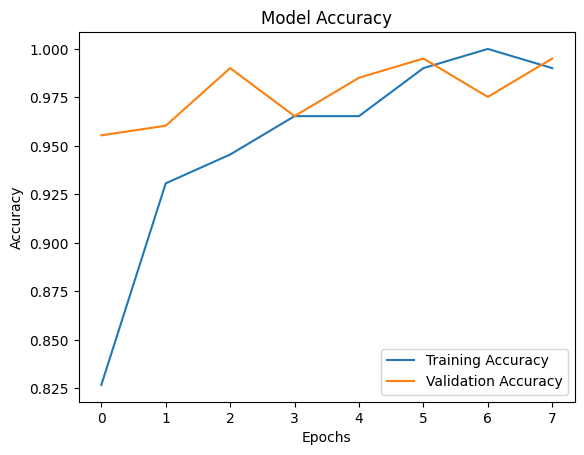

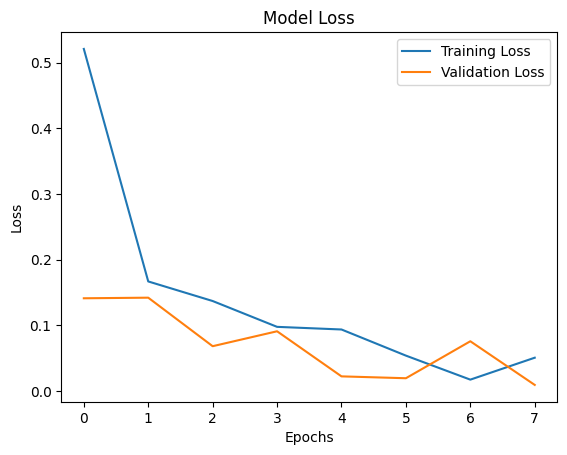

In [69]:
import json
import matplotlib.pyplot as plt

# Laden der JSON-Datei mit den Trainingsdaten
with open('train_history.json', 'r') as json_file:
    history_dict = json.load(json_file)

# Beispiel für das Plotten der Trainings- und Validierungsgenauigkeit
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Beispiel für das Plotten des Trainings- und Validierungsverlusts
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Predictions 

In [72]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 1. Lade das Bild, das du testen möchtest
img_path = r'cats_and_dogs_small\test\cats\1567.jpg'  # Pfad zum Bild, das du testen möchtest

# Lade das Bild und skaliere es auf die Eingabegröße des Modells
img = image.load_img(img_path, target_size=(224, 224))

# 2. Konvertiere das Bild in ein Array und normalisiere es
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Füge eine Batch-Dimension hinzu
img_array /= 255.0  # Normalisiere das Bild (falls beim Training auch normalisiert wurde)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Das Bild zeigt die Katzen Klasse.


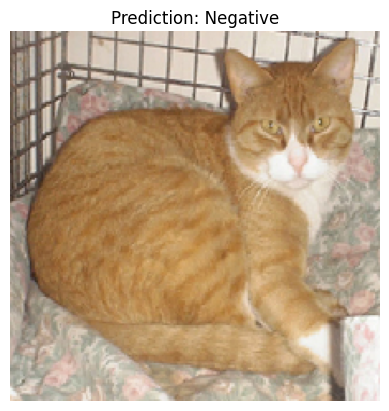

[[1.8859766e-05]]


In [73]:

# 3. Vorhersage des Modells
predictions = MobileNetV2_finetuned.predict(img_array)

# 4. Interpretiere die Vorhersage
# Hier nehmen wir an, dass es sich um ein binäres Klassifikationsproblem handelt
# (z.B. Hund vs. Katze)

# Bei binärer Klassifikation gibt das Modell eine Wahrscheinlichkeit zurück
# Wenn die Wahrscheinlichkeit größer als 0.5 ist, dann gehört das Bild zur positiven Klasse
if predictions[0] > 0.5:
    print("Das Bild zeigt die Hund Klasse.")
else:
    print("Das Bild zeigt die Katzen Klasse.")

# 5. (Optional) Visualisiere das Bild
plt.imshow(img)
plt.title(f'Prediction: {"Positive" if predictions[0] > 0.5 else "Negative"}')
plt.axis('off')  # Verstecke die Achsen
#plt.text(x=0,y=0,s=str(predictions))
plt.show()
print(predictions)

In [23]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Anzahl der Klassen
num_classes = 5  # Beispiel: Ändere dies zu der Anzahl der Klassen in deinem Problem

# Base model ohne die oberste Schicht laden
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Base model nicht trainierbar machen
base_model.trainable = False

# Neues Modell erstellen
MobileNetV2_finetuned = models.Sequential([
    base_model,  # MobileNetV2 als Basis
    layers.GlobalAveragePooling2D(),  # Global Average Pooling
    layers.Dense(1024, activation='relu'),  # Fully connected Layer
    layers.Dense(num_classes, activation='softmax')  # Ausgabeschicht für Mehrklassen-Klassifikation
])
# Kompiliere das Modell mit der passenden Loss-Funktion für Mehrklassen-Klassifikation
MobileNetV2_finetuned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator für das Training und die Validierung erstellen
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalisierung der Pixelwerte
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = r'user_pictures\100_pic_train'  # Trainingsdaten-Verzeichnis
validation_dir = r'user_pictures/100_pic_valid'  # Validierungsdaten-Verzeichnis

# Training-Daten-Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')  # Für Mehrklassen-Klassifikation

# Validierungs-Daten-Generator
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')  # Für Mehrklassen-Klassifikation


Found 202 images belonging to 2 classes.


Found 202 images belonging to 2 classes.


In [6]:
MobileNetV2_finetuned.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [17]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Pfad zum Bild
image_path = r'user_pictures\100_pic_test\cats\1567.jpg'

# Bild laden und vorverarbeiten
img = image.load_img(image_path, target_size=(224, 224))  # Größe muss zu deinem Modell passen
img_array = image.img_to_array(img)  # Bild in ein Array umwandeln
img_array = np.expand_dims(img_array, axis=0)  # Batch-Dimension hinzufügen
img_array = preprocess_input(img_array)  # Vorverarbeitung für MobileNetV2

# Vorhersage mit dem Modell
prediction = MobileNetV2_finetuned.predict(img_array)

# Vorhersage auswerten
predicted_class = np.argmax(prediction)  # Index der höchsten Wahrscheinlichkeit

# Laden der ImageNet-Klassen aus der Datei
with open('imagenet_classes.txt', 'r') as file:
    imagenet_classes = [line.strip() for line in file.readlines()]

# Überprüfen, ob der Index gültig ist
if predicted_class < len(imagenet_classes):
    predicted_label = imagenet_classes[predicted_class]
    print(f'Die vorhergesagte Klasse ist: {predicted_label} mit einer Wahrscheinlichkeit von {prediction[0][predicted_class]:.2f}')
else:
    print("Vorhergesagter Index liegt außerhalb des gültigen Bereichs der Klassenlabels.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Die vorhergesagte Klasse ist: great white shark mit einer Wahrscheinlichkeit von 0.34


In [ ]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder(r'cats_and_dogs_small')
print(builder.info)


In [36]:
raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_valid = builder.as_dataset(split='validation', shuffle_files=True)

In [37]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [38]:
base_model.trainable = False


In [46]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2)

In [47]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator für das Training und die Validierung erstellen
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalisierung der Pixelwerte
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = r'user_pictures\100_pic_train'  # Trainingsdaten-Verzeichnis
validation_dir = r'user_pictures/100_pic_valid'  # Validierungsdaten-Verzeichnis

# Training-Daten-Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')  # Für Mehrklassen-Klassifikation

# Validierungs-Daten-Generator
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')  # Für Mehrklassen-Klassifikation


Found 202 images belonging to 2 classes.


Found 202 images belonging to 2 classes.


In [49]:
validation_steps=20
initial_epochs = 20

loss0,accuracy0 = model.evaluate(validation_generator, steps = validation_steps)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.5566 - loss: 0.7556


C:\Users\riandrea\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [53]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator)


history_dict = history.history  # Das History-Objekt enthält alle Metriken
with open('Fine_train_history.json', 'w') as json_file:
        json.dump(history_dict, json_file, indent=4)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 752ms/step - accuracy: 0.9212 - loss: 0.2887 - val_accuracy: 0.9455 - val_loss: 0.2763
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 722ms/step - accuracy: 0.9325 - loss: 0.2737 - val_accuracy: 0.9554 - val_loss: 0.2660
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 735ms/step - accuracy: 0.9541 - loss: 0.2582 - val_accuracy: 0.9554 - val_loss: 0.2565
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 725ms/step - accuracy: 0.9549 - loss: 0.2419 - val_accuracy: 0.9554 - val_loss: 0.2473
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 722ms/step - accuracy: 0.9483 - loss: 0.2417 - val_accuracy: 0.9554 - val_loss: 0.2383
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 723ms/step - accuracy: 0.9436 - loss: 0.2611 - val_accuracy: 0.9554 - val_loss: 0.2301
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 723ms/step - accuracy: 0.9385 - loss: 0.2515 - val_accuracy: 0.9554 - val_loss: 0.2222
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 731ms/step - accuracy: 0.9646 - loss: 0.2214 - val_accuracy: 0.9604 - val_loss:

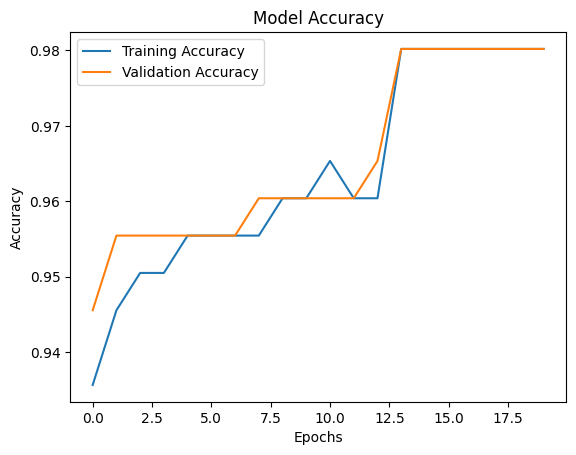

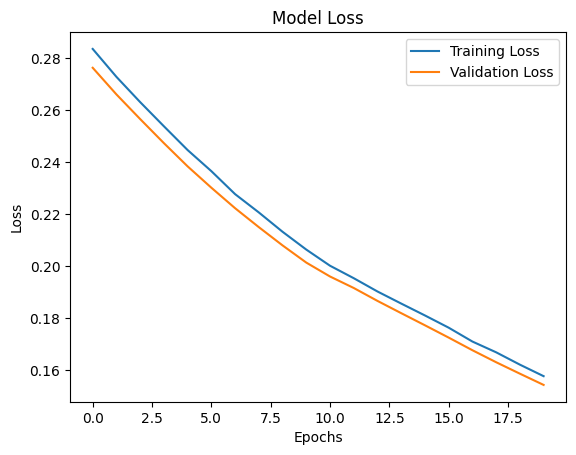

In [55]:
import json
import matplotlib.pyplot as plt

# Laden der JSON-Datei mit den Trainingsdaten
with open('Fine_train_history.json', 'r') as json_file:
    history_dict = json.load(json_file)

# Beispiel für das Plotten der Trainings- und Validierungsgenauigkeit
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Beispiel für das Plotten des Trainings- und Validierungsverlusts
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [56]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [57]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_generator)

Epoch 20/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8441 - loss: 0.3696 - val_accuracy: 0.9802 - val_loss: 0.1259
Epoch 21/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8893 - loss: 0.3300 - val_accuracy: 0.9802 - val_loss: 0.1120
Epoch 22/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 966ms/step - accuracy: 0.9490 - loss: 0.2197 - val_accuracy: 0.9851 - val_loss: 0.1004
Epoch 23/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 991ms/step - accuracy: 0.9540 - loss: 0.2075 - val_accuracy: 0.9901 - val_loss: 0.0911
Epoch 24/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 958ms/step - accuracy: 0.9898 - loss: 0.1726 - val_accuracy: 0.9950 - val_loss: 0.0822
Epoch 25/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 983ms/step - accuracy: 0.9846 - loss: 0.1547 - val_accuracy: 0.9950 - val_loss: 0.0749
Epoch 26/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 965ms/step - accuracy: 0.9931 - loss: 0.1380 - val_accuracy: 0.9950 - val_loss: 0.0676
Epoch 27/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 966ms/step - accuracy: 0.9947 - loss: 0.1112 - val_accuracy: 1.0000 - val_lo

In [58]:
# Beispiel für das Plotten der Trainings- und Validierungsgenauigkeit
plt.plot(history_fine['accuracy'], label='Training Accuracy')
plt.plot(history_fine['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Beispiel für das Plotten des Trainings- und Validierungsverlusts
plt.plot(history_fine['loss'], label='Training Loss')
plt.plot(history_fine['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

TypeError: 'History' object is not subscriptable

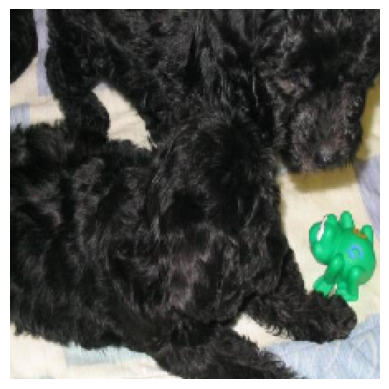

In [59]:
# Bild laden
image_path = r"cats_and_dogs_small\test\dogs\1509.jpg"

# Bild auf die gewünschte Eingabegröße skalieren unsere Modell nimmt 180 x 180 x3
img = image.load_img(image_path, target_size=(224, 224))

# Bild anzeigen
plt.imshow(img)
plt.axis("off")
plt.show()


In [60]:
img = imageio.imread(image_path)

# Bild auf die gewünschte Größe (224, 224) skalieren
img_resized = Image.fromarray(img).resize((224, 224))

# Bild in das numpy Array einfügen
data = np.empty((1, 224, 224, 3))
data[0] = np.array(img_resized)

In [61]:
data = preprocess_input(data)
data.shape

(1, 224, 224, 3)

In [67]:
predictions = history.predict(data)
print('Shape: {}'.format(predictions.shape))

AttributeError: 'History' object has no attribute 'predict'